#IBM HR Analytics Employee Attrition & Performance
>Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.

Education
1. 'Below College'
2. 'College'
3. 'Bachelor'
4. 'Master'
5. 'Doctor'

EnvironmentSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

JobInvolvement
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

JobSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

PerformanceRating
1. 'Low'
2. 'Good'
3. 'Excellent'
4. 'Outstanding'

RelationshipSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

WorkLifeBalance
1. 'Bad'
2. 'Good'
3. 'Better'
4. 'Best'Predict attrition of your valuable employees

In [2]:
# import the libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

##EDA

In [3]:
df = pd.read_csv("data/data.csv")
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [4]:
df.shape

(1470, 35)

In [5]:
df['Attrition'].value_counts()

,count
Attrition,
No,1233
Yes,237


Clearly, the negatives are oversampled

In [6]:
df.isnull().sum().sort_values()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [12]:
df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)

## Model Building

In [13]:
X = df.drop(columns='Attrition')
y = df['Attrition']

In [15]:
X = pd.get_dummies(X, drop_first=True)

In [16]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
# Imbalance calculation
ratio = (y == 0).sum() / (y == 1).sum()

models = {
        "logreg": LogisticRegression(max_iter=1000),
        "rf": RandomForestClassifier(n_estimators=300, random_state=42),
        "xgb": XGBClassifier(
            n_estimators=350,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=ratio,  # Handles 'No' > 'Yes' imbalance
            eval_metric="logloss",
            random_state=42
        ),
    }


In [47]:
best_auc = 0
best_model = None

for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"{name:10} | ROC-AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_model = model

print(f"\nFinal Choice: {best_model.__class__.__name__} with AUC {best_auc:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg     | ROC-AUC: 0.7268
rf         | ROC-AUC: 0.7882
xgb        | ROC-AUC: 0.7750

Final Choice: RandomForestClassifier with AUC 0.7882


In [48]:
import pickle
with open("model.bin", "wb") as f_m, open("feature_columns.bin", "wb") as f_f:
    pickle.dump(best_model, f_m)
    pickle.dump(X.columns.tolist(), f_f)

## Plotting feature importances

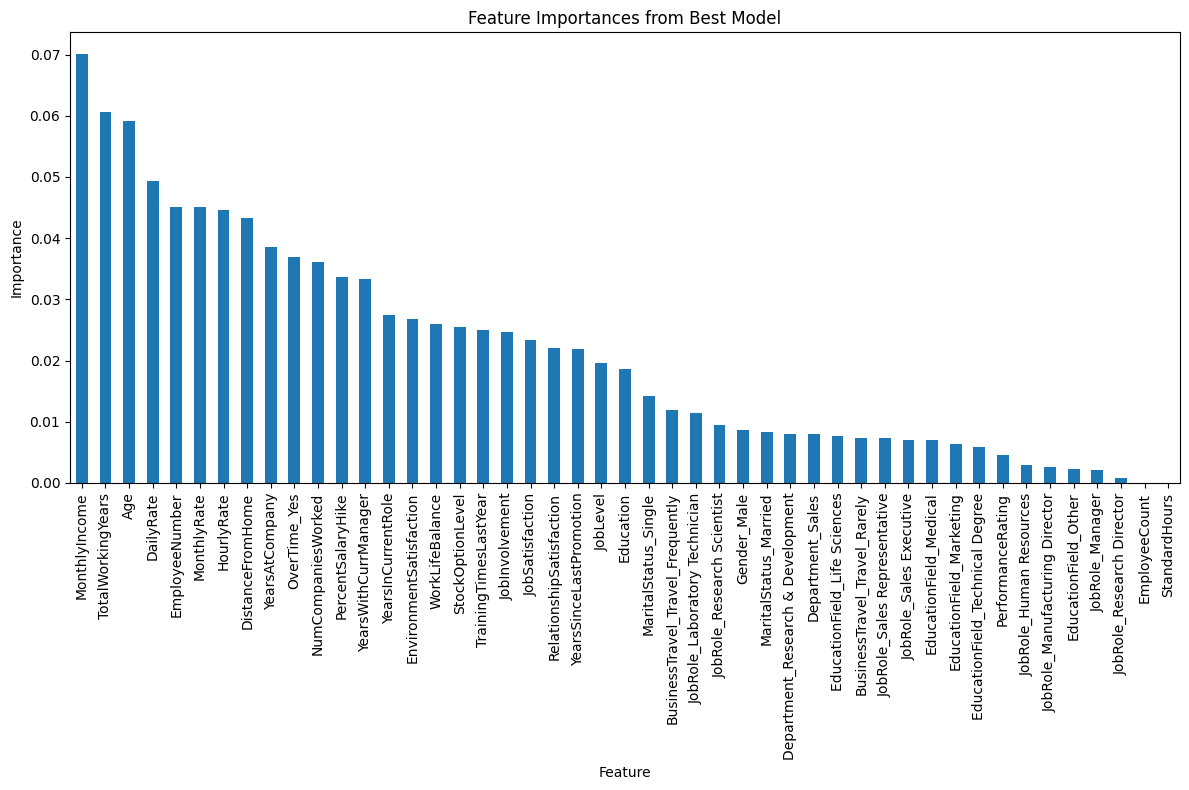

In [49]:
import matplotlib.pyplot as plt

# Get feature importances and their corresponding names
importances = best_model.feature_importances_
feature_names = X.columns

# Create a pandas Series for easier manipulation and plotting
feature_importance_series = pd.Series(importances, index=feature_names)

# Sort the features by importance in descending order
feature_importance_series = feature_importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importances from Best Model')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()